# Test response_time

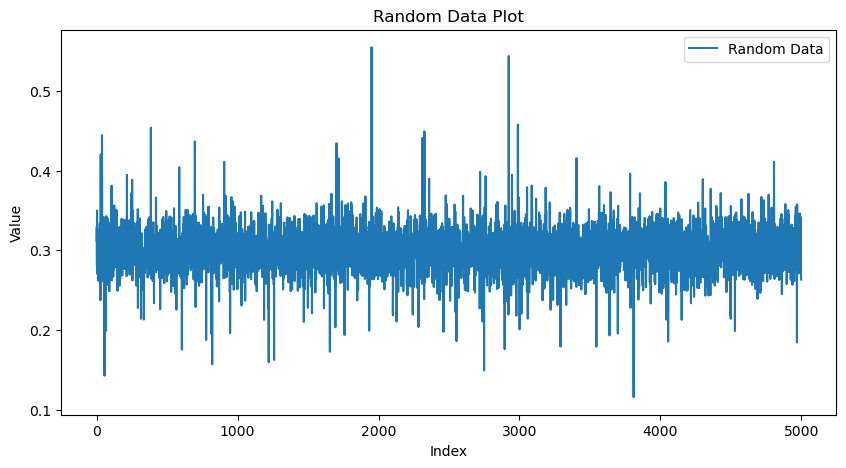

In [1]:
from model import ServiceConfig, ProcessingService
import logging
logging.basicConfig(
    format="%(asctime)s:%(levelname)s -- %(message)s", level=logging.INFO
)

# Sample response_time for communication between services
# config = {
#     "response_time_range": {
#         "max": 0.03,
#         "min": 0.006,
#         "avg": 0.02,
#         "base_scale": 10,
#         "spike_scale": 2,
#         "noise_scale": 20
#     },
#     "response_time_sim": 1
# }

# Sample response_time for processing service
# config = {
#     "response_time_range": {
#         "max": 0.01,
#         "min": 0.0012,
#         "avg": 0.003,
#         "base_scale": 30,
#         "spike_scale": 2,
#         "noise_scale": 20
#     },
#     "response_time_sim": 1
# }

# Sample aggregation response_time for ensemble service
# config = {
#     "response_time_range": {
#         "max": 0.02,
#         "min": 0.005,
#         "avg": 0.01,
#         "base_scale": 20,
#         "spike_scale": 2,
#         "noise_scale": 10
#     },
#     "response_time_sim": 1
# }

# Sample response_time for inference service
config = {
    "response_time_range": {
        "max": 0.5,
        "min": 0.1,
        "avg": 0.3,
        "base_scale": 40,
        "spike_scale": 3,
        "noise_scale": 20
    },
    "response_time_sim": 1
}

service_config = ServiceConfig.model_validate(config)
procesing_service = ProcessingService(service_config)
procesing_service.response_time_generator.plot_data()

# Test Pipeline

In [2]:
from model import ServiceConfig, ProcessingService, ServiceType, InferenceService, EnsembleService
import logging
import os
import time
import pandas as pd
import random
import copy
from collections import Counter
from rohe.common import rohe_utils as utils
from IPython.display import clear_output
logging.basicConfig(
    format="%(asctime)s:%(levelname)s -- %(message)s", level=logging.INFO
)
# Get data path of current file
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
# Default config file/path/requirement
MODEL_DATA_PATH = os.path.join(parent_dir, "profile/processed")
PROFILE_PATH = os.path.join(parent_dir, "profile/model_profile/model_profile.yaml")
CONFIG_PATH = os.path.join(current_dir, "sim_config.yaml")
FILE_DATA_PATH = os.path.join(current_dir, "file_label.csv")
THROUPUT_REQUIREMENT = 15

# Load profile data
profile_data = utils.load_config(PROFILE_PATH)

# Load data file
data_file_label = pd.read_csv(FILE_DATA_PATH).groupby("label")
labels = list(data_file_label.groups.keys())

# Init model profile
model_profile_data = {}

# Sample input data
init_data = {
    "input": {
        "file_name": "n01560419_3101",
        "image_height": 224,
        "image_width": 224
    }
}

# Init starting time
start_time = time.time()

# Init global variables
sim_config = None
distribution_keys = None
distribution_weights = None
procesing_service = None
ensemble_service = None
total_energy_consumption = 0


# Funtion for loading the EEMLS from config file
def config_pipeline():
    global sim_config
    global distribution_keys
    global distribution_weights
    global procesing_service
    global ensemble_service
    
    # Load simulation config
    sim_config = utils.load_config(CONFIG_PATH)
    
    # Load input distribution
    distribution = sim_config["distribution"]
    distribution_keys = list(distribution.keys())
    distribution_weights = list(distribution.values())
    
    # Load processing service config and create processing service
    if "processing" in sim_config:
        processing_config = sim_config["processing"]
        processing_config["service_type"] = ServiceType.PROCESSING.value
    processing_service_config = ServiceConfig.model_validate(processing_config)
    procesing_service = ProcessingService(processing_service_config)
        
    # Load ensemble service config and create ensemble service
    if "ensemble" in sim_config:
        ensemble_config = sim_config["ensemble"]
        ensemble_config["service_type"] = ServiceType.ENSEMBLE.value
    ensemble_config = ServiceConfig.model_validate(ensemble_config)
    ensemble_service = EnsembleService(ensemble_config)

    # Load inference service config and create inference service
    if "inference" in sim_config:
        inference_configs = sim_config["inference"]
        for i_name, i_config in inference_configs.items():
            i_config["throughput"] = profile_data[i_name]["throughput"] 
            i_config["energy"] = profile_data[i_name]["energy"] 
            i_config["response_time"] = profile_data[i_name]["response_time"]
            i_config["service_type"] = ServiceType.INFERENCE.value
            i_config["data_path"] = str(MODEL_DATA_PATH)
            i_config["throughput_requirement"] = int(sim_config["throughput_requirement"])
            inference_config = ServiceConfig.model_validate(i_config)
            inference_service = InferenceService(inference_config)
            ensemble_service.add_model(inference_service)

# Init the EEMLS
config_pipeline()

# Save the config file
# print(sim_config)
# temp_config_path = "sim_config.yaml"
# with open(temp_config_path, "w") as f:
#     yaml.dump(sim_config, f)

# Init number of inferences
inference_count = 0

# Start the simulation loop
while time.time() - start_time < 300:
    
    # Init input data
    data = copy.deepcopy(init_data)
    
    # Reload the EEMLS config after 500 inferences
    if inference_count % 500 == 0:
        config_pipeline()
    
    # Randomly select input data (class object) based on distribution
    selected_key = random.choices(distribution_keys, weights=distribution_weights, k=1)[0]
    if selected_key in labels:
        df_file = data_file_label.get_group(selected_key)
        file_name = random.choice(df_file["file_name"].values)
    
    # Update data with selected file
    data["input"]["file_name"] = file_name
    data["label"] = selected_key
    data["time_stamp"] = time.time()
    
    # Execute the pipeline
    data = procesing_service.execute(data)
    data = ensemble_service.execute(data)
    logging.debug(data)
    
    # Evaluate the inference results
    for model_name, inferences in data["ml_inference"].items():
        response_time = data["response_time"]["inference"][model_name]
        i_label = data["label"]
        if i_label in list(inferences.keys()):
            i_accuracy = 1
            i_confidence = inferences[i_label]
        else:
            i_accuracy = 0
            i_confidence = 0
        model_contribution = 0
        if model_name in list(data["contribution"].keys()):
            model_contribution = data["contribution"][model_name]

        # Save the inference results to model profile as dataframe
        data_dict = {
            "time_stamp": [data["time_stamp"]],
            "label": [i_label],
            "accuracy": [i_accuracy],
            "confidence": [i_confidence],
            "file_name": [data["input"]["file_name"]],
            "reponse_time": [response_time],
            "explainability": [data["explainability"][model_name]],
            "contribution": [model_contribution]
        }
        result_df = pd.DataFrame(data_dict)
        if model_name not in model_profile_data:
            model_profile_data[model_name] = {}
            model_profile_data[model_name]["data_frame"] = result_df
        else:
            model_profile_data[model_name]["data_frame"] = pd.concat([model_profile_data[model_name]["data_frame"], 
                                                                    result_df], 
                                                                    ignore_index=True)
    
    # Increase the inference count
    inference_count += 1

    # Evaluate models and ensemble in EEMLS every 500 inferences
    if inference_count % 500 == 0:
        for model_name, model_data in model_profile_data.items():
            recent_df = model_data["data_frame"].tail(10000)
            # save the last 10000 inference results of each model to csv
            recent_df.to_csv(f"results/inference/{model_name}_inference.csv")
            
            if "profile" not in model_data:
                model_data["profile"] = {}

            # Calculate the overall performance metrics
            overall_accuracy = recent_df["accuracy"].mean()
            overall_confidence = recent_df["confidence"].mean()
            overall_avg_response_time = recent_df["reponse_time"].mean()
            overall_max_response_time = recent_df["reponse_time"].max()
            overall_explainability = recent_df["explainability"].mean()
            overall_contribution = recent_df["contribution"].mean()
            if "overall" not in model_data["profile"]:
                model_data["profile"]["overall"] = {}
            model_data["profile"]["overall"]["accuracy"] = overall_accuracy
            model_data["profile"]["overall"]["confidence"] = overall_confidence
            model_data["profile"]["overall"]["avg_response_time"] = overall_avg_response_time
            model_data["profile"]["overall"]["max_response_time"] = overall_max_response_time
            model_data["profile"]["overall"]["explainability"] = overall_explainability
            model_data["profile"]["overall"]["contribution"] = overall_contribution
            
            # Calculate the performance metrics for each class label
            grouped_df = recent_df.groupby("label")
            for label, group in grouped_df:
                accuracy = group["accuracy"].mean()
                confidence = group["confidence"].mean()
                avg_response_time = group["reponse_time"].mean()
                max_response_time = group["reponse_time"].max()
                explainability = group["explainability"].mean()
                contribution = group["contribution"].mean()
                if label not in model_data["profile"]:
                    model_data["profile"][label] = {}
                model_data["profile"][label]["accuracy"] = accuracy
                model_data["profile"][label]["confidence"] = confidence
                model_data["profile"][label]["avg_response_time"] = avg_response_time
                model_data["profile"][label]["max_response_time"] = max_response_time
                model_data["profile"][label]["explainability"] = explainability
                model_data["profile"][label]["contribution"] = contribution

        # Clear previous output
        clear_output(wait=True)
        
        # Print the performance metrics
        for model_name, model_data in model_profile_data.items():
            logging.info(model_name)
            logging.info(model_data["profile"])
            
        # Calculate the energy consumption
        energy_report = ensemble_service.energy_estimate()
        total_energy_consumption += energy_report["ensemble"]
        energy_report["total_energy_consumption"] = total_energy_consumption
        logging.info(energy_report)
 

2024-11-23 17:41:11,773:INFO -- ResNet50V2
2024-11-23 17:41:11,773:INFO -- {'overall': {'accuracy': 0.7246, 'confidence': 0.6572068429976702, 'avg_response_time': 0.11681037858294237, 'max_response_time': 0.20990102801168384, 'explainability': 0.0, 'contribution': 0.7305236029356718}, 'n01440764': {'accuracy': 0.7768679631525077, 'confidence': 0.7357401056872908, 'avg_response_time': 0.11688567423421846, 'max_response_time': 0.18513760719604974, 'explainability': 0.0, 'contribution': 0.7885937851032923}, 'n01443537': {'accuracy': 0.8829365079365079, 'confidence': 0.84675283913338, 'avg_response_time': 0.11678610111185571, 'max_response_time': 0.20990102801168384, 'explainability': 0.0, 'contribution': 0.867116018139299}, 'n01484850': {'accuracy': 0.6109762020398252, 'confidence': 0.5142023506646252, 'avg_response_time': 0.11690577906134637, 'max_response_time': 0.1864884294853938, 'explainability': 0.0, 'contribution': 0.6260681777917511}, 'n01491361': {'accuracy': 0.6191425722831505, 

KeyboardInterrupt: 

# My own simulation to get STATE


In [ ]:
from model_rl import ServiceConfig, ProcessingService, ServiceType, InferenceService, EnsembleService
import logging
import os
import time
import pandas as pd
import random
import copy
from collections import Counter
from rohe.common import rohe_utils as utils
from IPython.display import clear_output
import yaml

# Configure logging
logging.basicConfig(format="%(asctime)s:%(levelname)s -- %(message)s", level=logging.INFO)

# Paths and configurations
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
MODEL_DATA_PATH = os.path.join(parent_dir, "profile/processed")
PROFILE_PATH = os.path.join(parent_dir, "profile/model_profile/model_profile.yaml")
CONFIG_PATH = os.path.join(current_dir, "sim_config.yaml")
FILE_DATA_PATH = os.path.join(current_dir, "file_label.csv")
THROUGHPUT_REQUIREMENT = 15

initial_yaml_file_path = "initial_sim_config.yaml"  # Ensure this path matches your desired location
# Load contents from the initial YAML file
with open(initial_yaml_file_path, "r") as initial_file:
    initial_yaml_content = yaml.safe_load(initial_file)

# Write the loaded contents into the target YAML file
with open(CONFIG_PATH, "w") as target_file:
    yaml.dump(initial_yaml_content, target_file, default_flow_style=False)

print(f"Contents of {initial_yaml_file_path} have been dumped into {CONFIG_PATH}.")

# Load necessary data
profile_data = utils.load_config(PROFILE_PATH)
data_file_label = pd.read_csv(FILE_DATA_PATH).groupby("label")
labels = list(data_file_label.groups.keys())
model_profile_data = {}

# Input data example
init_data = {
    "input": {
        "file_name": "n01560419_3101",
        "image_height": 224,
        "image_width": 224,
    }
}

# Global variables
sim_config = None
distribution_keys = None
distribution_weights = None
processing_service = None
ensemble_service = None
total_energy_consumption = 0


# CONFIGURING THE PIPELINE
def config_pipeline():
    global sim_config, distribution_keys, distribution_weights, processing_service, ensemble_service

    # Load simulation config
    sim_config = utils.load_config(CONFIG_PATH)

    # Input distribution
    distribution = sim_config["distribution"]
    distribution_keys = list(distribution.keys())
    distribution_weights = list(distribution.values())

    # Create processing service
    if "processing" in sim_config:
        processing_config = sim_config["processing"]
        processing_config["service_type"] = ServiceType.PROCESSING.value
        processing_service_config = ServiceConfig.model_validate(processing_config)
        processing_service = ProcessingService(processing_service_config)

    # Create ensemble service
    if "ensemble" in sim_config:
        ensemble_config = sim_config["ensemble"]
        ensemble_config["service_type"] = ServiceType.ENSEMBLE.value
        ensemble_service_config = ServiceConfig.model_validate(ensemble_config)
        ensemble_service = EnsembleService(ensemble_service_config)

    # Add inference services to ensemble
    if "inference" in sim_config:
        inference_configs = sim_config["inference"]
        for model_name, model_config in inference_configs.items():
            model_config["throughput"] = profile_data[model_name]["throughput"]
            model_config["energy"] = profile_data[model_name]["energy"]
            model_config["response_time"] = profile_data[model_name]["response_time"]
            model_config["service_type"] = ServiceType.INFERENCE.value
            model_config["data_path"] = str(MODEL_DATA_PATH)
            model_config["throughput_requirement"] = int(sim_config["throughput_requirement"])
            inference_service_config = ServiceConfig.model_validate(model_config)
            inference_service = InferenceService(inference_service_config)
            ensemble_service.add_model(inference_service)


# EXTRACT STATE FOR RL

def get_state(data):
    # Ensemble-level metrics
    energy_report = ensemble_service.energy_estimate()
    ensemble_state = {
        "total_energy_consumption": total_energy_consumption + energy_report["ensemble"],
        "ensemble_size": len(ensemble_service.ensemble),
    }

    # Model-level metrics
    model_states = []
    for model_name, model_data in model_profile_data.items():
        # Directly compute metrics from data_frame
        if "data_frame" in model_data:
            recent_df = model_data["data_frame"].tail(10000)  # Use recent 10,000 entries
            accuracy = recent_df["accuracy"].mean()
            confidence = recent_df["confidence"].mean()
            avg_response_time = recent_df["response_time"].mean()
            max_response_time = recent_df["response_time"].max()
            contribution = recent_df["contribution"].mean()

            model_states.append({
                "name": model_name,
                "accuracy": accuracy,
                "confidence": confidence,
                "avg_response_time": avg_response_time,
                "max_response_time": max_response_time,
                "contribution": contribution,
            })

    # Input state
    input_state = {
        "current_label": data["label"],
        "file_name": data["input"]["file_name"],
    }

    # Combine state
    state = {
        "ensemble": ensemble_state,
        "models": model_states,
        "input": input_state,
    }
    return state


# APPLYING RL ACTIONS
def apply_action(action):
    if action == "add_model":
        logging.info("Action: Adding a model")
        # Logic for adding a new model (Placeholder)
    elif action == "replace_model":
        logging.info("Action: Replacing a model")
        # Logic for replacing a model (Placeholder)
    elif action == "keep_ensemble":
        logging.info("Action: Keeping the ensemble")
    else:
        logging.warning("Unknown action")


# Initialize the pipeline
config_pipeline()

# SIMULATION LOOP
# RL Simulation Loop
start_time = time.time()
inference_count = 0
while time.time() - start_time < 300:  # Run for 300 seconds
    # Prepare input data
    data = copy.deepcopy(init_data)
    selected_key = random.choices(distribution_keys, weights=distribution_weights, k=1)[0]
    if selected_key in labels:
        df_file = data_file_label.get_group(selected_key)
        file_name = random.choice(df_file["file_name"].values)
    data["input"]["file_name"] = file_name
    data["label"] = selected_key

    # Execute services
    data = processing_service.execute(data)
    data = ensemble_service.execute(data)

    # Update model profiles
    for model_name, inferences in data["ml_inference"].items():
        response_time = data["response_time"]["inference"].get(model_name, 0)
        i_label = data["label"]
        i_accuracy = 1 if i_label in inferences else 0
        i_confidence = inferences.get(i_label, 0)
        model_contribution = data["contribution"].get(model_name, 0)

        # Save to profile data
        data_dict = {
            "label": [i_label],
            "accuracy": [i_accuracy],
            "confidence": [i_confidence],
            "response_time": [response_time],
            "contribution": [model_contribution],
        }
        result_df = pd.DataFrame(data_dict)
        if model_name not in model_profile_data:
            model_profile_data[model_name] = {"data_frame": result_df}
        else:
            model_profile_data[model_name]["data_frame"] = pd.concat(
                [model_profile_data[model_name]["data_frame"], result_df], ignore_index=True
            )
        logging.info(model_name)
        logging.info(result_df)
    
    # Get RL state and decide an action
    state = get_state(data)
    print(state)
    action = "keep_ensemble"  # Example: Replace with RL agent's action logic
    apply_action(action)

    # Increment inference count
    inference_count += 1

    # Periodically save results
    if inference_count % 500 == 0:
        logging.info(f"Inference Count: {inference_count}")
        for model_name, model_data in model_profile_data.items():
            model_data["data_frame"].tail(10000).to_csv(f"results/inference/{model_name}_inference.csv")
    
    #Use this to run only one
    break

logging.info("Simulation complete!")


TypeError: cannot pickle '_io.TextIOWrapper' object